In [1]:
import numpy as np
import pandas as pd
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from datetime import datetime
from pyproj import CRS
import string
from datetime import datetime
import osmnx as ox
import scipy
from sklearn import preprocessing, cluster

%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12,8)
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

In [2]:
full_data = pd.read_excel('shanghai_gps.xlsx', skiprows=6, header=0)
full_data.columns = ['_'.join(name.lower().translate(str.maketrans(' ', ' ', string.punctuation)).split()) for name in full_data.columns]

In [3]:
full_data.head()

,uid,date_in_days,week,start_time_in_seconds,end_time_in_seconds,start_longitude,start_latitude,end_longitude,end_latitude,activitytrip,trip_mode,start_location,end_location,activity_type
0,146,15996,5,1382053013,1382053037,121.483090,31.281703,121.483142,31.281787,0,0,0,0,0
1,146,15996,5,1382053282,1382056978,121.483192,31.281846,121.420448,31.207532,1,7,0,-1,1
2,146,15996,5,1382066805,1382066995,121.420343,31.207485,121.421642,31.206600,0,0,-1,-1,1
3,146,16216,1,1401056822,1401056998,121.431495,31.202385,121.431598,31.200608,0,0,-1,-1,-1
4,146,16216,1,1401057000,1401059946,121.431599,31.200593,121.431700,31.024567,1,6,-1,-1,1


In [4]:
full_data.duplicated().sum()

0

In [5]:
full_data.isna().sum()

uid                      0
date_in_days             0
week                     0
start_time_in_seconds    0
end_time_in_seconds      0
start_longitude          0
start_latitude           0
end_longitude            0
end_latitude             0
activitytrip             0
trip_mode                0
start_location           0
end_location             0
activity_type            0
dtype: int64

activity_type           -0.381815
uid                     -0.066495
activitytrip            -0.039329
start_time_in_seconds   -0.033744
end_time_in_seconds     -0.033625
date_in_days            -0.033525
end_latitude            -0.030079
start_latitude          -0.028953
week                    -0.025488
trip_mode               -0.019798
start_longitude          0.029577
end_longitude            0.032796
start_location           0.524159
end_location             1.000000
Name: end_location, dtype: float64


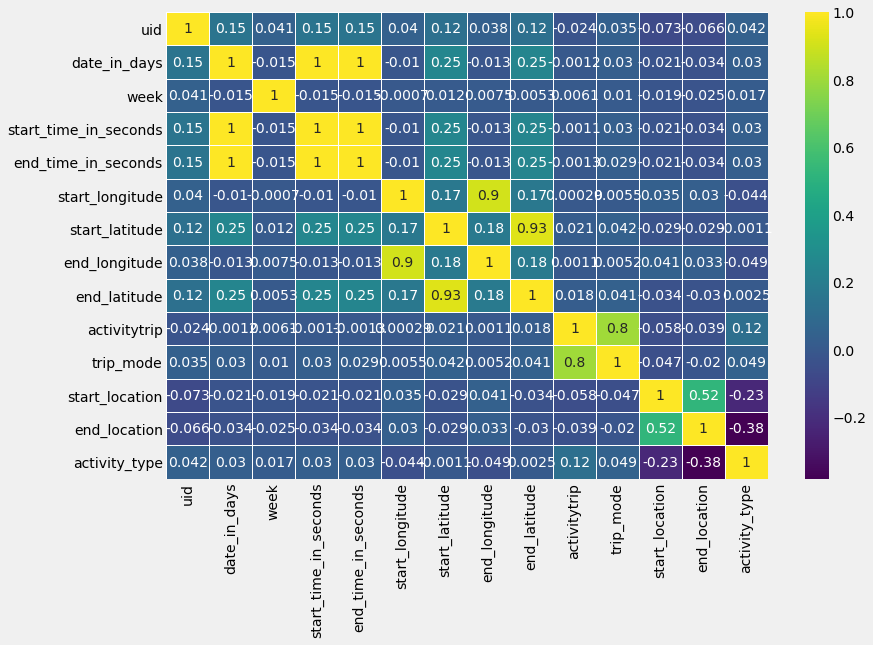

In [6]:
target_corr = full_data.corr()['end_location'].sort_values()
print(target_corr)
ax = sns.heatmap(full_data.corr(), annot=True, linewidths=0.5, cmap ='viridis')

# Feature Engineering on Trips

## Datetime Features

In [7]:
full_data['duration_in_seconds'] = full_data.apply(lambda x: x['end_time_in_seconds']-x['start_time_in_seconds'], axis=1)

def transform_time(X):
        X = X.copy()
        # Engineer temporal features
        X['start_datetime'] = pd.to_datetime(X['start_time_in_seconds'],unit='s')
        X['end_datetime'] = pd.to_datetime(X['end_time_in_seconds'],unit='s')
        X['start_month'] = X['start_datetime'].dt.month
        X['start_day'] = X['start_datetime'].dt.day
        X['start_day_of_week'] = X['start_datetime'].dt.dayofweek
        X['start_hour_of_day'] = X['start_datetime'].dt.hour
        X['start_minute_of_hour'] = X['start_datetime'].dt.minute
        X['end_month'] = X['end_datetime'].dt.month
        X['end_day'] = X['end_datetime'].dt.day
        X['end_day_of_week'] = X['end_datetime'].dt.dayofweek
        X['end_hour_of_day'] = X['end_datetime'].dt.hour
        X['end_minute_of_hour'] = X['end_datetime'].dt.minute
#         X.drop(['start_time_in_seconds', 'end_time_in_seconds'], axis=1, inplace=True)
        return X
    
new_data = transform_time(full_data)

In [8]:
new_data.drop(['date_in_days','week','activitytrip','trip_mode','start_location','end_location','activity_type'], axis=1,inplace=True)

In [9]:
from geopy import distance
import math
def calculate_great_circle_distance(start_latitude, start_longitude, end_latitude, end_longitude):
    pickup = [start_latitude, start_longitude]
    dropoff = [end_latitude, end_longitude]
    dist = distance.great_circle(pickup, dropoff).km
    return dist

def calculate_manhattan_distance(start_latitude, start_longitude, end_latitude, end_longitude):
    pickup = [start_latitude, start_longitude]
    dropoff_a = [start_latitude,end_longitude]
    dropoff_b = [end_latitude, start_longitude]
    distance_a = distance.great_circle(pickup, dropoff_a).km
    distance_b = distance.great_circle(pickup, dropoff_b).km
    return distance_a + distance_b

def calculate_bearing(start_latitude, start_longitude, end_latitude, end_longitude):
    d_lon = end_longitude-start_longitude
    y = math.sin(d_lon)*math.cos(end_latitude)
    x = math.cos(start_latitude)*math.sin(end_latitude) - math.sin(start_latitude)*math.cos(end_latitude)*math.cos(d_lon)
    bearing = math.atan2(y,x)
    if bearing < 0: 
        bearing+=2*math.pi
    return bearing

In [10]:
lat_lng_data = new_data[['start_latitude','start_longitude','end_latitude','end_longitude']]
new_data['gc_dist'] = new_data.apply(lambda x: calculate_great_circle_distance(x.start_latitude,x.start_longitude,x.end_latitude,x.end_longitude),axis=1)
new_data['mn_dist'] = new_data.apply(lambda x: calculate_manhattan_distance(x.start_latitude,x.start_longitude,x.end_latitude,x.end_longitude),axis=1)
new_data['bearing'] = new_data.apply(lambda x: calculate_bearing(x.start_latitude,x.start_longitude,x.end_latitude,x.end_longitude),axis=1)

<AxesSubplot:>

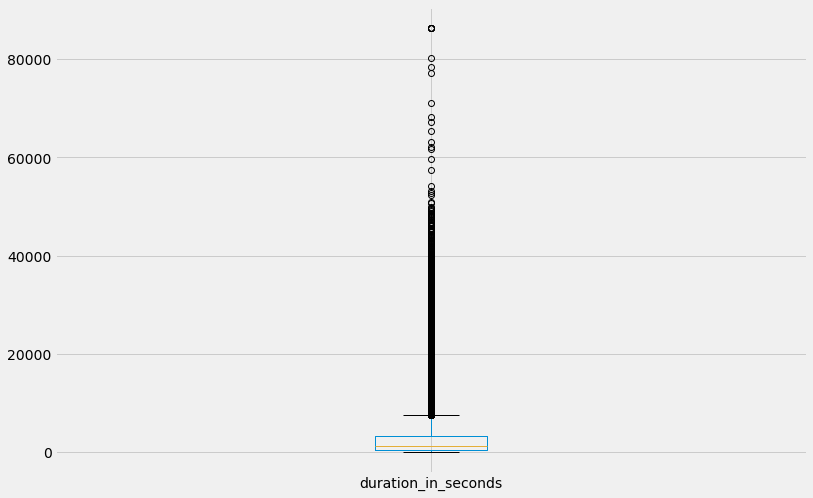

In [11]:
full_data.boxplot(column='duration_in_seconds')

In [12]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10408 entries, 0 to 10407
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   uid                    10408 non-null  int64         
 1   start_time_in_seconds  10408 non-null  int64         
 2   end_time_in_seconds    10408 non-null  int64         
 3   start_longitude        10408 non-null  float64       
 4   start_latitude         10408 non-null  float64       
 5   end_longitude          10408 non-null  float64       
 6   end_latitude           10408 non-null  float64       
 7   duration_in_seconds    10408 non-null  float64       
 8   start_datetime         10408 non-null  datetime64[ns]
 9   end_datetime           10408 non-null  datetime64[ns]
 10  start_month            10408 non-null  int64         
 11  start_day              10408 non-null  int64         
 12  start_day_of_week      10408 non-null  int64         
 13  s

In [13]:
new_data['tid'] = full_data.index
new_data['user_trip_id'] = full_data.sort_values(by=['uid','start_time_in_seconds']).groupby('uid', sort=False).cumcount()+1
new_data.head()

,uid,start_time_in_seconds,end_time_in_seconds,start_longitude,start_latitude,end_longitude,end_latitude,duration_in_seconds,start_datetime,end_datetime,start_month,start_day,start_day_of_week,start_hour_of_day,start_minute_of_hour,end_month,end_day,end_day_of_week,end_hour_of_day,end_minute_of_hour,gc_dist,mn_dist,bearing,tid,user_trip_id
0,146,1382053013,1382053037,121.483090,31.281703,121.483142,31.281787,24.0,2013-10-17 23:36:53,2013-10-17 23:37:17,10,17,3,23,36,10,17,3,23,37,0.010574,0.014313,0.555492,0,1
1,146,1382053282,1382056978,121.483192,31.281846,121.420448,31.207532,3696.0,2013-10-17 23:41:22,2013-10-18 00:42:58,10,17,3,23,41,10,18,4,0,42,10.191332,14.225922,3.830444,1,2
2,146,1382066805,1382066995,121.420343,31.207485,121.421642,31.206600,190.0,2013-10-18 03:26:45,2013-10-18 03:29:55,10,18,4,3,26,10,18,4,3,29,0.157957,0.221971,2.179451,2,3
3,146,1401056822,1401056998,121.431495,31.202385,121.431598,31.200608,176.0,2014-05-25 22:27:02,2014-05-25 22:29:58,5,25,6,22,27,5,25,6,22,29,0.197837,0.207444,3.084705,3,4
4,146,1401057000,1401059946,121.431599,31.200593,121.431700,31.024567,2946.0,2014-05-25 22:30:00,2014-05-25 23:19:06,5,25,6,22,30,5,25,6,23,19,19.573227,19.582868,3.141057,4,5


## Model

In [14]:
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV
numerical_cols = list(new_data.dtypes[(new_data.dtypes != 'object') & (new_data.dtypes != 'datetime64[ns]')].index)
numerical_cols.remove('tid')
numeric_df = new_data[numerical_cols]
print(numerical_cols)
print(len(numerical_cols))
print(numeric_df.shape)
# print(numerical_cols)

['uid', 'start_time_in_seconds', 'end_time_in_seconds', 'start_longitude', 'start_latitude', 'end_longitude', 'end_latitude', 'duration_in_seconds', 'start_month', 'start_day', 'start_day_of_week', 'start_hour_of_day', 'start_minute_of_hour', 'end_month', 'end_day', 'end_day_of_week', 'end_hour_of_day', 'end_minute_of_hour', 'gc_dist', 'mn_dist', 'bearing', 'user_trip_id']
22
(10408, 22)


In [15]:
numeric_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10408 entries, 0 to 10407
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   uid                    10408 non-null  int64  
 1   start_time_in_seconds  10408 non-null  int64  
 2   end_time_in_seconds    10408 non-null  int64  
 3   start_longitude        10408 non-null  float64
 4   start_latitude         10408 non-null  float64
 5   end_longitude          10408 non-null  float64
 6   end_latitude           10408 non-null  float64
 7   duration_in_seconds    10408 non-null  float64
 8   start_month            10408 non-null  int64  
 9   start_day              10408 non-null  int64  
 10  start_day_of_week      10408 non-null  int64  
 11  start_hour_of_day      10408 non-null  int64  
 12  start_minute_of_hour   10408 non-null  int64  
 13  end_month              10408 non-null  int64  
 14  end_day                10408 non-null  int64  
 15  en

In [16]:
train, df_test = train_test_split(numeric_df)
df_train, df_valid = train_test_split(train)
df_train.shape, df_valid.shape, df_test.shape

((5854, 22), (1952, 22), (2602, 22))

In [17]:
# Isolation Forest ----
from sklearn.ensemble import IsolationForest
# training the model
clf = IsolationForest(max_samples=100, random_state=13)
clf.fit(df_train)
# predictions
y_pred_train = clf.predict(df_train)
y_pred_test = clf.predict(df_test)
# y_pred_outliers = clf.predict(X_outliers)

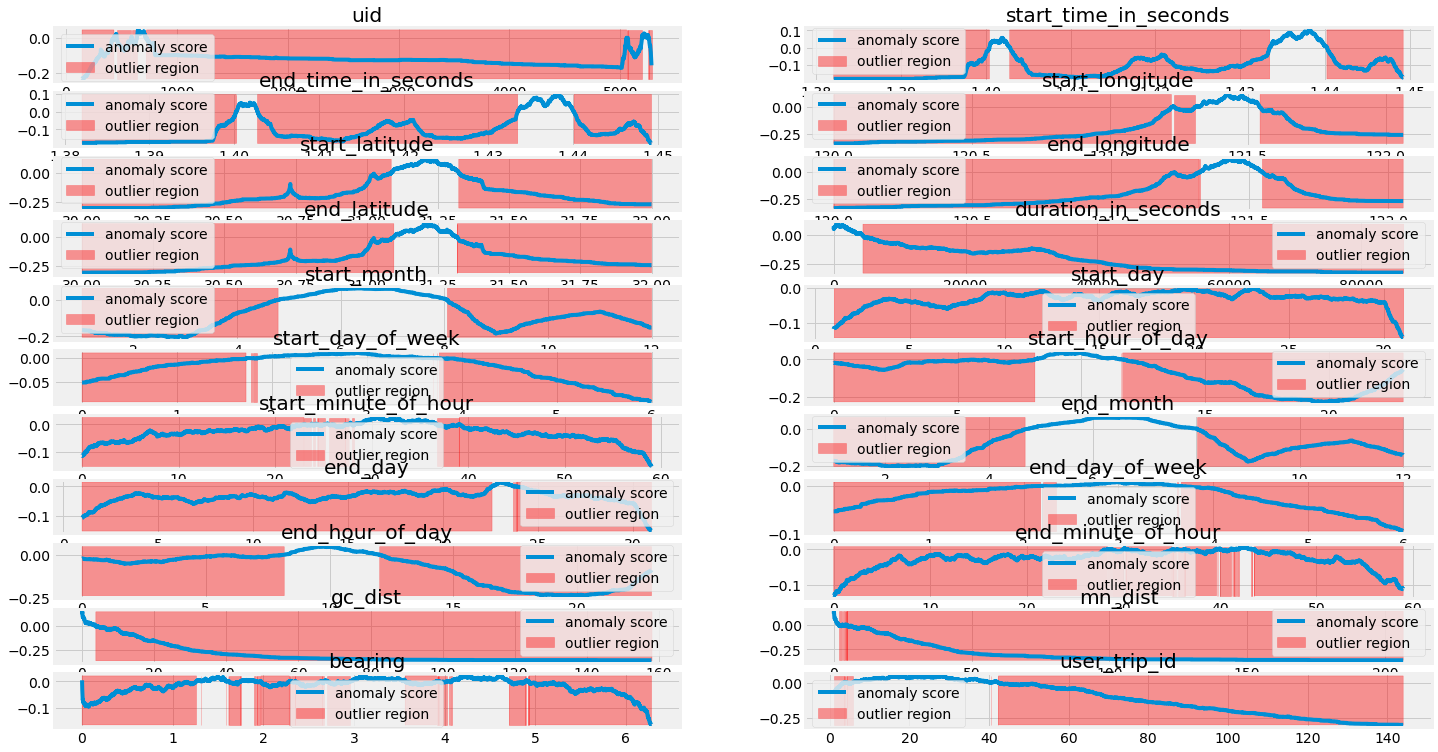

In [18]:
fig, axs = plt.subplots(11, 2, figsize=(22, 12), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i, column in enumerate(numerical_cols):
    isolation_forest = IsolationForest(contamination='auto')
    isolation_forest.fit(numeric_df[column].values.reshape(-1,1))

    xx = np.linspace(numeric_df[column].min(), numeric_df[column].max(), len(numeric_df)).reshape(-1,1)
    anomaly_score = isolation_forest.decision_function(xx)
    outlier = isolation_forest.predict(xx)
    
    axs[i].plot(xx, anomaly_score, label='anomaly score')
    axs[i].fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                     where=outlier==-1, color='r', 
                     alpha=.4, label='outlier region')
    axs[i].legend()
    axs[i].set_title(column)

In [19]:
# perform normalization and PCA and output components
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize
X_normalized = pd.DataFrame(normalize(StandardScaler().fit_transform(numeric_df)))

pca_99 = PCA(n_components = 0.99)
pca_99.fit(X_normalized)
reduced = pca_99.transform(X_normalized)

X_pc = PCA(n_components = 2).fit_transform(X_normalized)
X_principal = pd.DataFrame(X_pc)
X_principal.columns = ['P1', 'P2']

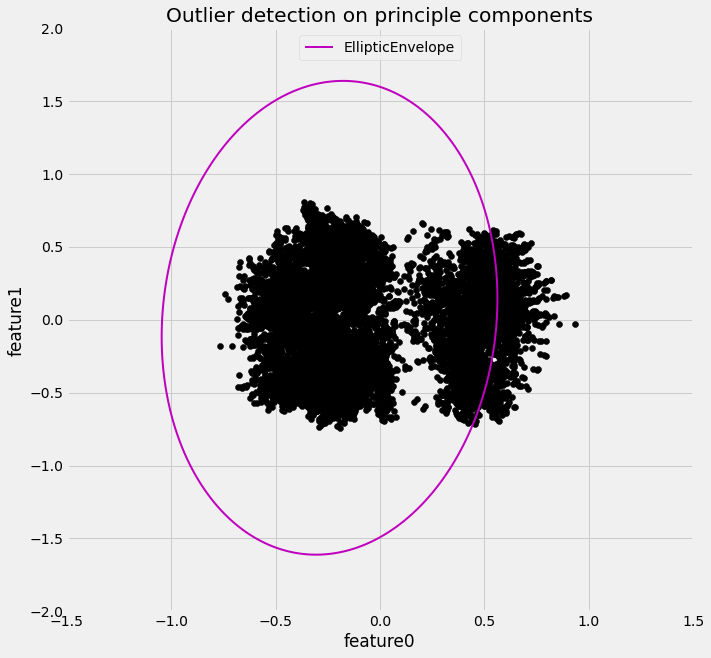

In [20]:
from sklearn.covariance import EllipticEnvelope
clf = EllipticEnvelope()

legend = {}
xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, 500), np.linspace(-2, 2, 500))
plt.figure(1, figsize=(10,10))
clf.fit(X_principal)
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
legend['EllipticEnvelope'] = plt.contour(
    xx, yy, Z, levels=[0], linewidths=2, colors=['m'])

legend_values_list = list(legend.values())
legend_keys_list = list(legend.keys())

plt.figure(1, figsize=(10,10))# two clusters
plt.title("Outlier detection on principle components")
plt.scatter(X_principal['P1'], X_principal['P2'], color='black')
bbox_args = dict(boxstyle="round", fc="0.8")
arrow_args = dict(arrowstyle="->")

plt.xlim((xx.min(), xx.max()))
plt.ylim((yy.min(), yy.max()))
plt.legend(legend_values_list[0].collections, legend_keys_list,
           loc="upper center");
plt.ylabel("feature1");
plt.xlabel("feature0");

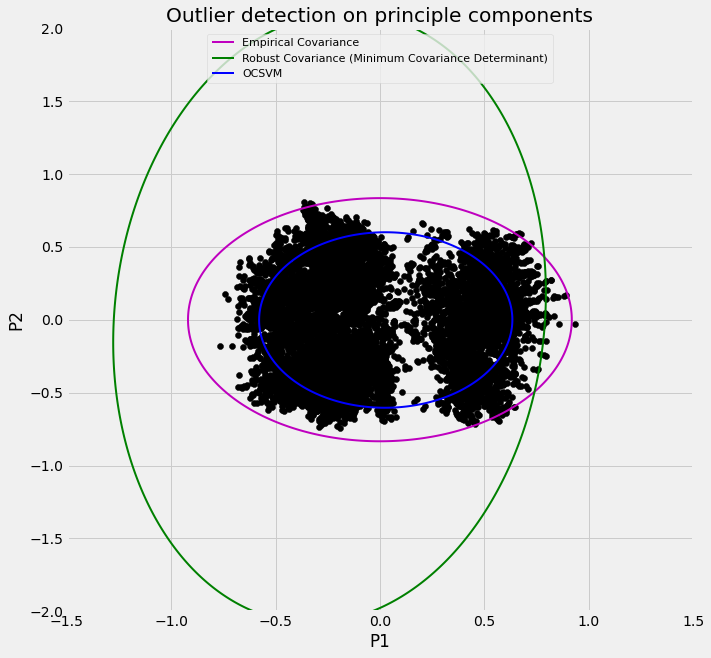

In [21]:
from sklearn.svm import OneClassSVM
import matplotlib
classifiers = {
    "Empirical Covariance": EllipticEnvelope(support_fraction=1.,
                                             contamination=0.002),
    "Robust Covariance (Minimum Covariance Determinant)":
    EllipticEnvelope(contamination=0.002),
    "OCSVM": OneClassSVM(nu=0.25, gamma=0.35)}
colors = ['m', 'g', 'b']
legend1 = {}
legend2 = {}

X1 = X_pc

xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, 500), np.linspace(-2, 2, 500))

for i, (clf_name, clf) in enumerate(classifiers.items()):
    plt.figure(1, figsize=(10,10))
    clf.fit(X_principal)
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    legend1[clf_name] = plt.contour(
        xx, yy, Z, levels=[0], linewidths=2, colors=colors[i])

legend1_values_list = list(legend1.values())
legend1_keys_list = list(legend1.keys())

# Plot the results (= shape of the data points cloud)
plt.figure(1, figsize=(10,10))# two clusters
plt.title("Outlier detection on principle components")
plt.scatter(X_principal['P1'], X_principal['P2'], color='black')
bbox_args = dict(boxstyle="round", fc="0.8")
arrow_args = dict(arrowstyle="->")
# plt.annotate("outlying points", xy=(4, 2),
#              xycoords="data", textcoords="data",
#              xytext=(3, 1.25), bbox=bbox_args, arrowprops=arrow_args)
plt.xlim((xx.min(), xx.max()))
plt.ylim((yy.min(), yy.max()))
plt.legend((legend1_values_list[0].collections[0],
            legend1_values_list[1].collections[0],
            legend1_values_list[2].collections[0]),
           (legend1_keys_list[0], legend1_keys_list[1], legend1_keys_list[2]),
           loc="upper center",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.ylabel("P2")
plt.xlabel("P1")

plt.show()

<AxesSubplot:>

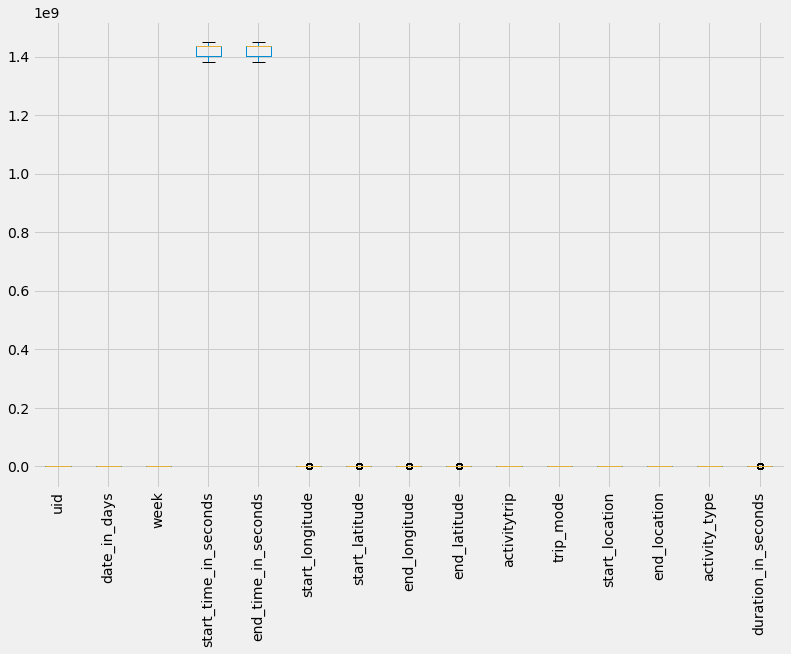

In [22]:
full_data.plot(kind='box', rot=90)

In [4]:
heads = 106
tails = 122
what_we_want = heads
total = heads+tails
rel_freq = what_we_want/total
print(rel_freq)

0.4649122807017544


In [23]:
new_data.uid.astype('category').describe()

count     10408
unique      281
top        5094
freq        144
Name: uid, dtype: int64

In [24]:
target_user = new_data[new_data.uid == 5094]

In [25]:
target_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 6604 to 6747
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   uid                    144 non-null    int64         
 1   start_time_in_seconds  144 non-null    int64         
 2   end_time_in_seconds    144 non-null    int64         
 3   start_longitude        144 non-null    float64       
 4   start_latitude         144 non-null    float64       
 5   end_longitude          144 non-null    float64       
 6   end_latitude           144 non-null    float64       
 7   duration_in_seconds    144 non-null    float64       
 8   start_datetime         144 non-null    datetime64[ns]
 9   end_datetime           144 non-null    datetime64[ns]
 10  start_month            144 non-null    int64         
 11  start_day              144 non-null    int64         
 12  start_day_of_week      144 non-null    int64         
 13  s

In [31]:
# for i in range(2, 26):
#     km = cluster.MiniBatchKMeans(n_clusters=i)
#     km.fit_predict(temp_gdf)
#     ssd.append(km.inertia_)
new_data.columns

Index(['uid', 'start_time_in_seconds', 'end_time_in_seconds',
       'start_longitude', 'start_latitude', 'end_longitude', 'end_latitude',
       'duration_in_seconds', 'start_datetime', 'end_datetime', 'start_month',
       'start_day', 'start_day_of_week', 'start_hour_of_day',
       'start_minute_of_hour', 'end_month', 'end_day', 'end_day_of_week',
       'end_hour_of_day', 'end_minute_of_hour', 'gc_dist', 'mn_dist',
       'bearing', 'tid', 'user_trip_id'],
      dtype='object')

In [29]:
start_df = new_data[['uid', 'start_time_in_seconds', 'start_longitude', 'start_latitude', 'start_month', 'start_day', 'start_day_of_week','start_hour_of_day','start_minute_of_hour']]
end_df = new_data[['uid', 'end_time_in_seconds', 'end_longitude', 'end_latitude', 'end_month', 'end_day', 'end_day_of_week','end_hour_of_day','end_minute_of_hour']]
end_df.columns = start_df.columns
temp_gdf = pd.concat([start_df,end_df])

In [30]:
temp_gdf = temp_gdf[['uid','tid','start_time_in_seconds','start_longitude','start_latitude']]
temp_gdf.columns = ['uid','tid','timestamp','longitude','latitude']

<AxesSubplot:>

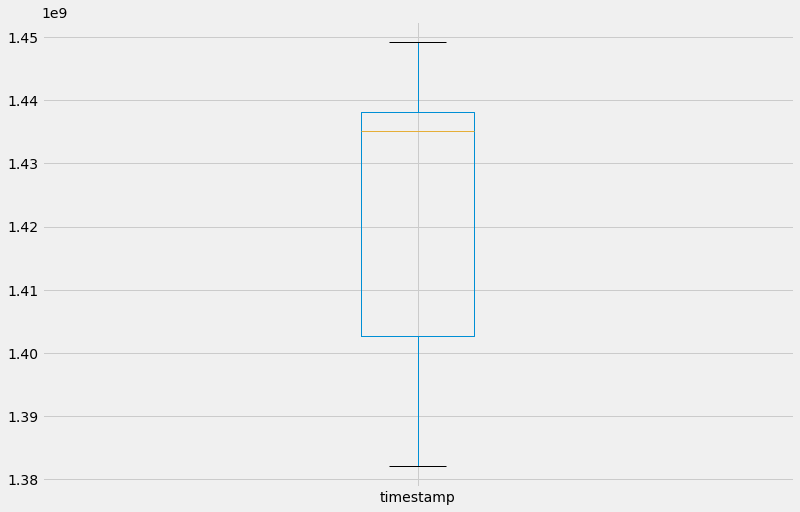

In [32]:
temp_gdf.boxplot(column='timestamp')

In [ ]:
# temp_gdf['timestamp'] = pd.to_datetime(temp_gdf.timestamp, unit='s')

In [34]:
temp_gdf.isna().sum()
temp_gdf.head()

,uid,tid,timestamp,longitude,latitude,geometry
0,146,0,1382053013,121.483090,31.281703,POINT (121.48309 31.28170)
1,146,1,1382053282,121.483192,31.281846,POINT (121.48319 31.28185)
2,146,2,1382066805,121.420343,31.207485,POINT (121.42034 31.20749)
3,146,3,1401056822,121.431495,31.202385,POINT (121.43149 31.20239)
4,146,4,1401057000,121.431599,31.200593,POINT (121.43160 31.20059)


In [ ]:
print(tdf.datetime.sample(30))

In [33]:
gdf = gpd.GeoDataFrame(temp_gdf, geometry=gpd.points_from_xy(temp_gdf.longitude, temp_gdf.latitude))
# temp_gdf.timestamp.describe()

In [ ]:
gdf.head()

In [ ]:
G = ox.graph_from_place('Shanghai, China', network_type='drive', simplify=True, retain_all=False, truncate_by_edge=True)
fig, ax = ox.plot_graph(G, show=False, close=False)
# ax.scatter(gdf['longitude'], gdf['latitude'], c=gdf.color)
lat = temp_gdf.latitude
lng = temp_gdf.longitude
sns.kdeplot(x=lng, y=lat, cmap="magma", shade=True, thresh=0.05)
plt.show()

In [35]:
import geoplot as gplt
import geoplot.crs as gcrs
G = ox.graph_from_place('Shanghai, China', network_type='walk', simplify=True, retain_all=False, truncate_by_edge=True)

In [36]:
Gp = ox.project_graph(G)
Gc = ox.consolidate_intersections(Gp, rebuild_graph=True, tolerance=20, dead_ends=False)
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

In [37]:
nodes.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 88564 entries, 91410243 to 8242010553
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   y             88564 non-null  float64 
 1   x             88564 non-null  float64 
 2   street_count  88564 non-null  int64   
 3   highway       3676 non-null   object  
 4   ref           68 non-null     object  
 5   geometry      88564 non-null  geometry
dtypes: float64(2), geometry(1), int64(1), object(2)
memory usage: 4.7+ MB


In [38]:
points_list = gpd.GeoSeries(gdf.geometry.to_list(),crs="EPSG:4326")
points_proj = points_list.to_crs(Gp.graph['crs'])

In [39]:
gdf['nearest_node'] = ox.distance.nearest_nodes(G, gdf.longitude.to_numpy(), gdf.latitude.to_numpy())
nns = gdf.nearest_node.values.tolist()
nodes['visits'] = nodes.index.map(lambda x: nns.count(x))
nodes.describe()

,y,x,street_count,visits
count,88564.000000,88564.000000,88564.000000,88564.000000
mean,31.152140,121.449299,2.906576,0.235039
std,0.150755,0.208567,0.990994,2.509869
min,30.691161,120.861980,1.000000,0.000000
25%,31.054229,121.313499,3.000000,0.000000
50%,31.192690,121.458895,3.000000,0.000000
75%,31.253830,121.570355,4.000000,0.000000
max,31.511308,121.972410,8.000000,248.000000


In [44]:
user_df = gdf.groupby(['uid', 'nearest_node']).timestamp.count().reset_index(name='count')

In [45]:
node_df = user_df.pivot(index='uid', columns='nearest_node', values='count').fillna(0)

In [48]:
R = node_df.values
user_visits_mean = np.mean(R, axis = 1)
R_demeaned = R - user_visits_mean.reshape(-1, 1)

In [49]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(R_demeaned, k = 50)
sigma = np.diag(sigma)
all_user_predicted_visits = np.dot(np.dot(U,sigma),Vt)+user_visits_mean.reshape(-1, 1)

In [ ]:
G2 = ox.graph_from_gdfs(nodes,edges)
# nc = ox.plot.get_node_colors_by_attr(G2,'visits', num_bins=20)
ox.plot_graph(G2,node_size=nodes['visits'], node_color=nodes['visits'])

In [ ]:
fig, ax = ox.plot_graph(G, show=False, close=False)
ax.scatter(gdf['longitude'], gdf['latitude'], c=gdf.color)

In [ ]:

model = cluster.DBSCAN()
dtf = gdf.copy()
X = gdf[['latitude','longitude']]
dtf_X = X.copy()
dtf_X["cluster"] = model.fit_predict(X)


# closest, distances = scipy.cluster.vq.vq(model.cluster_centers_, 
#                      dtf_X.drop("cluster", axis=1).values)
# dtf_X["centroids"] = 0
# for i in closest:
#     dtf_X["centroids"].iloc[i] = 1
# dtf[["cluster","centroids"]] = dtf_X[["cluster","centroids"]]

In [ ]:
import geopy
city = "Shanghai"
locator = geopy.geocoders.Nominatim(user_agent="MyCoder")
location = locator.geocode(city)
location = [location.latitude, location.longitude]
print("[lat, long]:", location)

In [ ]:
import movingpandas as mpd
true_gdf = gdf[['geometry','timestamp']].sort_values(by='timestamp')
true_gdf.info()
traj = mpd.Trajectory(true_gdf,1)

In [ ]:
import statistics
prevalence = 2.8/1000

In [ ]:
from sklearn.ensemble import IsolationForest
model=IsolationForest(contamination=prevalence)
model.fit(temp_gdf)